In [1]:
import os
import numpy as np
import gc
import joblib
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from ogb.lsc import PCQM4Mv2Dataset
import torch
from sklearn.linear_model import HuberRegressor

In [9]:
# Point to competition dataset directory
ROOT = '../dataset'
dataset = PCQM4Mv2Dataset(root = ROOT, only_smiles =True)

# Convert to Dataframe: smiles + target
train = pd.DataFrame({
    'smiles': [dataset[i][0] for i in range(len(dataset))],
    'target': [dataset[i][1] for i in range(len(dataset))],
})
train['id'] = np.arange(train.shape[0])

splits = torch.load('../input/new_split_dict.pt')
split_dict = dataset.get_idx_split()
train_idx = split_dict['train'] # numpy array storing indices of training molecules
valid_idx = split_dict['valid'] # numpy array storing indices of validation molecules
testdev_idx = split_dict['test-dev'] # numpy array storing indices of test-dev molecules
testchallenge_idx = split_dict['test-challenge'] # numpy array storing indices of test-challenge molecules
for f in range(4):
    train[f'fold{f}'] = 0
    train.loc[train['id'].isin(splits[f'valid_{f}']), f'fold{f}'] = 1
    train.loc[train['id'].isin(testdev_idx), f'fold{f}'] = 2
    train.loc[train['id'].isin(testchallenge_idx), f'fold{f}'] = 3

train.head()

,smiles,target,id,fold0,fold1,fold2,fold3
0,O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C,3.047675,0,0,0,0,0
1,COc1cc(OC)ccc1/C=C/N(C(=O)C)C,4.410966,1,1,0,0,0
2,C=CCN(C(=O)C)/C=C/c1ccccc1C,4.639541,2,0,0,0,0
3,C=CCN(C(=O)C)/C=C/c1ccccc1F,4.492600,3,0,0,0,0
4,C=CCN(C(=O)C)/C=C/c1ccccc1Cl,4.612330,4,0,0,0,0


In [10]:
valid0 = train.loc[train.fold0==1].reset_index(drop=True)
valid1 = train.loc[train.fold1==1].reset_index(drop=True)
valid2 = train.loc[train.fold2==1].reset_index(drop=True)
valid3 = train.loc[train.fold3==1].reset_index(drop=True)

valid0['len'] = valid0['smiles'].apply(len)
valid1['len'] = valid1['smiles'].apply(len)
valid2['len'] = valid2['smiles'].apply(len)
valid3['len'] = valid3['smiles'].apply(len)

dtest = train.loc[
    (train.fold0<=1)&
    (train.fold1<=1)&
    (train.fold2<=1)&
    (train.fold3<=1)
].reset_index(drop=True)
dtest = dtest.groupby('smiles')['target'].agg('median')

valid0.shape, valid1.shape, valid2.shape, valid3.shape

((143840, 8), (143840, 8), (143840, 8), (143840, 8))

In [11]:
BASEPATH = 'model_oofs/predictions/'
!ls model_oofs/predictions

alexandrem_tm18forreal_withnodepred_400_1_fold0_0.07596
alexandrem_tm18forreal_withnodepred_400_1_fold1_0.07790
alexandrem_tm18forreal_withnodepred_400_1_fold2_0.07941
alexandrem_tm18forreal_withnodepred_400_1_fold3_0.07932
alexandrem_tm18forreal_withnodepred_400_2_fold0_0.07865
alexandrem_tm18forreal_withnodepred_400_2_fold1_0.07744
alexandrem_tm18forreal_withnodepred_400_2_fold2_0.07892
alexandrem_tm18forreal_withnodepred_400_2_fold3_0.07926
alexandrem_tm18_nonodepred_400_fold0_0.07645
alexandrem_tm18_nonodepred_400_fold1_0.07583
alexandrem_tm18_nonodepred_400_fold2_0.07591
alexandrem_tm18_nonodepred_400_fold3_0.07596
cpmp_256_bs64_lr1e-4_fold0
cpmp_256_bs64_lr1e-4_fold1
cpmp_256_bs64_lr1e-4_fold2
cpmp_256_bs64_lr1e-4_fold3
cpmp_256_fold0
cpmp_256_fold1
cpmp_256_fold2
cpmp_256_fold3
dummy
giba_effb3_352_fold0
giba_effb3_352_fold1
giba_effb3_352_fold2
giba_effb3_352_fold3
giba_resnet_352_fold0
giba_resnet_352_fold1
giba_resnet_352_fold2
giba_resnet_352_fold3
jiwei_a81b8a4_kfold_submit

In [12]:
!ls -l model_oofs/predictions/

total 216
drwxrwxr-x 2 giba giba 4096 out 31 17:22 alexandrem_tm18forreal_withnodepred_400_1_fold0_0.07596
drwxrwxr-x 2 giba giba 4096 out 31 17:22 alexandrem_tm18forreal_withnodepred_400_1_fold1_0.07790
drwxrwxr-x 2 giba giba 4096 out 31 17:22 alexandrem_tm18forreal_withnodepred_400_1_fold2_0.07941
drwxrwxr-x 2 giba giba 4096 out 31 17:22 alexandrem_tm18forreal_withnodepred_400_1_fold3_0.07932
drwxrwxr-x 2 giba giba 4096 out 31 17:22 alexandrem_tm18forreal_withnodepred_400_2_fold0_0.07865
drwxrwxr-x 2 giba giba 4096 out 31 17:22 alexandrem_tm18forreal_withnodepred_400_2_fold1_0.07744
drwxrwxr-x 2 giba giba 4096 out 31 17:22 alexandrem_tm18forreal_withnodepred_400_2_fold2_0.07892
drwxrwxr-x 2 giba giba 4096 out 31 17:22 alexandrem_tm18forreal_withnodepred_400_2_fold3_0.07926
drwxrwxr-x 2 giba giba 4096 out 29 11:16 alexandrem_tm18_nonodepred_400_fold0_0.07645
drwxrwxr-x 2 giba giba 4096 out 29 11:16 alexandrem_tm18_nonodepred_400_fold1_0.07583
drwxrwxr-x 2 giba giba 4096 out 29 11:16 a

In [13]:
oof_files = [
    [
    'alexandrem_tm18_nonodepred_400_fold0_0.07645',
    'cpmp_256_bs64_lr1e-4_fold0',
    'jiwei_b29872e_fold0_valid_0.0846',
    'sajad_blv1_18l_454_3407_val_fold0_0.07434',
    'giba_resnet_352_fold0',
    'giba_effb3_352_fold0',
    'alexandrem_tm18forreal_withnodepred_400_1_fold0_0.07596',
    'alexandrem_tm18forreal_withnodepred_400_2_fold0_0.07865',
    'sajad_blv2-0.2_18l_val_fold0_0.07477',
    'sajad_blv2_r_0.1_18l_454_3407_val_fold0_0.07478',
    'sajad_blv4_no_dihedral_18l_val_fold0_0.07469',
    'dummy',
    ],
    [
    'alexandrem_tm18_nonodepred_400_fold1_0.07583',
    'cpmp_256_bs64_lr1e-4_fold1',
    'jiwei_b29872e_fold1_valid_0.0841',
    'sajad_blv1_18l_454_3407_val_fold1_0.07409',
    'giba_resnet_352_fold1',
    'giba_effb3_352_fold1',
    'alexandrem_tm18forreal_withnodepred_400_1_fold1_0.07790',
    'alexandrem_tm18forreal_withnodepred_400_2_fold1_0.07744',
    'dummy',
    'sajad_blv2_r_0.1_18l_454_3407_val_fold1_0.07448',
    'sajad_blv4_no_dihedral_18l_val_fold1_0.07434',
    'sajad_blv5__18l_454_3407_val_fold1_0.07424',
    ],    
    [
    'alexandrem_tm18_nonodepred_400_fold2_0.07591',
    'cpmp_256_bs64_lr1e-4_fold2',
    'jiwei_b29872e_fold2_valid_0.0841',
    'sajad_blv1_18l_454_3407_val_fold2_0.07386',
    'giba_resnet_352_fold2',
    'giba_effb3_352_fold2',
    'alexandrem_tm18forreal_withnodepred_400_1_fold2_0.07941',
    'alexandrem_tm18forreal_withnodepred_400_2_fold2_0.07892',
    'sajad_blv2-0.2_18l_val_fold2_0.07417',
    'dummy',
    'sajad_blv4_no_dihedral_18l_val_fold2_0.07416',
    'sajad_blv5__18l_454_3407_val_fold2_0.07416',
    ],    
    [
    'alexandrem_tm18_nonodepred_400_fold3_0.07596',
    'cpmp_256_bs64_lr1e-4_fold3',
    'jiwei_b29872e_fold3_valid_0.0841',
    'sajad_blv1_18l_454_3407_val_fold3_0.07396',
    'giba_resnet_352_fold3',
    'giba_effb3_352_fold3',
    'alexandrem_tm18forreal_withnodepred_400_1_fold3_0.07932',
    'alexandrem_tm18forreal_withnodepred_400_2_fold3_0.07926',
    'sajad_blv2-0.2_18l_val_fold3_0.07410',
    'sajad_blv2_r_0.1_18l_454_3407_val_fold3_0.07421',
    'dummy',
    'sajad_blv5__18l_454_3407_val_fold3_0.07414'
    ],    
]

VALID = []
TEST = []
for n, files in enumerate(oof_files):
    print(f'Split: {n}')
    valid = train.loc[train[f"fold{n}"]==1].reset_index(drop=True)
    valid['split'] = n

    test = train.loc[train[f"fold{n}"]==3].reset_index(drop=True)
    test['split'] = n
    
    for f, fn in enumerate(files):
        print(f"Loading {fn}")
        
        #Check if oof file exists, otherwise load dummy 0 values to the fold
        if fn != 'dummy':
            oof = np.load(BASEPATH + fn + '/valid.npy').flatten()
            valid[f'oof{f}'] = oof.astype('float32')
        else:
            valid[f'oof{f}'] = 0.
            
        oof = np.load(BASEPATH + fn + '/testchallenge.npy').flatten()
        test[f'oof{f}'] = oof.astype('float32')
        
    VALID.append(valid.reset_index(drop=True))
    TEST.append(test.reset_index(drop=True))
    print()

VALID = pd.concat(VALID)
TEST = pd.concat(TEST)

len(VALID), len(TEST)

Split: 0
Loading alexandrem_tm18_nonodepred_400_fold0_0.07645
Loading cpmp_256_bs64_lr1e-4_fold0
Loading jiwei_b29872e_fold0_valid_0.0846
Loading sajad_blv1_18l_454_3407_val_fold0_0.07434
Loading giba_resnet_352_fold0
Loading giba_effb3_352_fold0
Loading alexandrem_tm18forreal_withnodepred_400_1_fold0_0.07596
Loading alexandrem_tm18forreal_withnodepred_400_2_fold0_0.07865
Loading sajad_blv2-0.2_18l_val_fold0_0.07477
Loading sajad_blv2_r_0.1_18l_454_3407_val_fold0_0.07478
Loading sajad_blv4_no_dihedral_18l_val_fold0_0.07469
Loading dummy

Split: 1
Loading alexandrem_tm18_nonodepred_400_fold1_0.07583
Loading cpmp_256_bs64_lr1e-4_fold1
Loading jiwei_b29872e_fold1_valid_0.0841
Loading sajad_blv1_18l_454_3407_val_fold1_0.07409
Loading giba_resnet_352_fold1
Loading giba_effb3_352_fold1
Loading alexandrem_tm18forreal_withnodepred_400_1_fold1_0.07790
Loading alexandrem_tm18forreal_withnodepred_400_2_fold1_0.07744
Loading dummy
Loading sajad_blv2_r_0.1_18l_454_3407_val_fold1_0.07448
Loading saj

(575360, 589728)

In [14]:
VALID.head()

,smiles,target,id,fold,fold0,fold1,fold2,fold3,num_atoms,split,...,oof2,oof3,oof4,oof5,oof6,oof7,oof8,oof9,oof10,oof11
0,COc1cc(OC)ccc1/C=C/N(C(=O)C)C,4.410966,1,1,1,0,0,0,17,0,...,4.393664,4.388084,4.426374,4.412532,4.373395,4.376553,4.427334,4.400160,4.396652,0.0
1,O[C@@H]1CCN(C[C@H]1O)[C@H](c1ccccc1)C,5.994668,21,1,1,0,0,0,16,0,...,5.991448,5.923240,5.955681,5.876278,5.959333,5.923428,5.950772,5.919691,5.923996,0.0
2,S=C1[N]C2=N[C]3[C@H](N2N1)C=CC=C3,2.397323,27,1,1,0,0,0,13,0,...,2.335269,2.302146,2.233330,2.375889,2.369489,2.368741,2.417569,2.368910,2.336105,0.0
3,CC[C@@H]1C[C@@H](O)[C@@H](C(=O)C1)c1ccccc1,5.825958,37,1,1,0,0,0,16,0,...,6.003646,5.938865,5.752470,5.809436,5.889020,5.888272,5.903897,5.904066,5.896652,0.0
4,CC[C@H](CC(OC)OC)/C=C/c1ccccc1,5.099414,39,1,1,0,0,0,17,0,...,5.094391,5.087303,5.085454,5.075472,5.084333,5.083584,5.091397,5.087660,5.095871,0.0


In [15]:
TEST.head()

,smiles,target,id,fold,fold0,fold1,fold2,fold3,num_atoms,split,...,oof2,oof3,oof4,oof5,oof6,oof7,oof8,oof9,oof10,oof11
0,C[C@H]1CC[C@H]2C=CC[C@H]2[CH][N]N[C]([N]1)S,NaN,3378615,3,3,3,3,3,15,0,...,5.676093,5.532615,5.599783,5.523482,5.545270,5.360928,5.548428,5.505629,5.525558,0.0
1,COCC/N=C(\N/N=C/1\C[C@H]2[C@@H]1CC=C2)/S,NaN,3378616,3,3,3,3,3,16,0,...,5.530355,5.524803,5.504106,5.529464,5.517927,5.505459,5.497647,5.525160,5.525558,0.0
2,CC(C[C@@H](/N=C(\c1cccc(c1)Cl)/O)C)C,NaN,3378620,3,3,3,3,3,16,0,...,5.546458,5.552146,5.675616,5.477852,5.541364,5.548428,5.548428,5.556410,5.548996,0.0
3,CC(C[C@H](/N=C(\c1cccc(c1)Cl)/O)C)C,NaN,3378621,3,3,3,3,3,16,0,...,5.547314,5.552146,5.676899,5.504450,5.541364,5.548428,5.548428,5.556410,5.548996,0.0
4,N#CSc1ccc(c(c1)N(=O)=O)/N=C(/O)\C,NaN,3378622,3,3,3,3,3,16,0,...,4.249443,4.317771,4.131842,4.219999,4.342145,4.255459,4.360928,4.333754,4.298996,0.0


In [16]:
VALID['oof12'] = 0
VALID.loc[VALID['oof8']>0, 'oof12'] += VALID.loc[VALID['oof8']>0, 'oof8']
VALID.loc[VALID['oof9']>0, 'oof12'] += VALID.loc[VALID['oof9']>0, 'oof9']
VALID.loc[VALID['oof10']>0, 'oof12'] += VALID.loc[VALID['oof10']>0, 'oof10']
VALID.loc[VALID['oof11']>0, 'oof12'] += VALID.loc[VALID['oof11']>0, 'oof11']
VALID['oof12'] /= 3.

In [17]:
TEST['oof12'] = 0
TEST.loc[TEST['oof8']>0, 'oof12'] += TEST.loc[TEST['oof8']>0, 'oof8']
TEST.loc[TEST['oof9']>0, 'oof12'] += TEST.loc[TEST['oof9']>0, 'oof9']
TEST.loc[TEST['oof10']>0, 'oof12'] += TEST.loc[TEST['oof10']>0, 'oof10']
TEST.loc[TEST['oof11']>0, 'oof12'] += TEST.loc[TEST['oof11']>0, 'oof11']
TEST['oof12'] /= 3.

<AxesSubplot:>

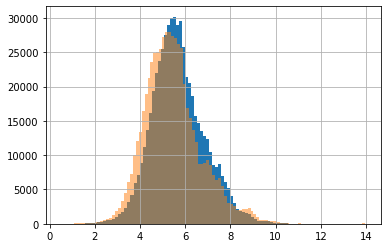

In [20]:
VALID['oof12'].hist(bins=100)
TEST['oof12'].hist(bins=100, alpha=0.5)

In [21]:
for model in range(13):
    VALID['error'] = (VALID['target'] - VALID[f'oof{model}']).abs()
    print(VALID.groupby(['split'])['error'].mean())

split
0    0.076451
1    0.075836
2    0.075917
3    0.075966
Name: error, dtype: float64
split
0    0.079534
1    0.079366
2    0.079198
3    0.079090
Name: error, dtype: float64
split
0    0.084606
1    0.084109
2    0.084103
3    0.084054
Name: error, dtype: float64
split
0    0.074345
1    0.074089
2    0.073861
3    0.073959
Name: error, dtype: float64
split
0    0.098702
1    0.097201
2    0.099301
3    0.098005
Name: error, dtype: float64
split
0    0.092380
1    0.092456
2    0.092663
3    0.092523
Name: error, dtype: float64
split
0    0.074996
1    0.077910
2    0.079415
3    0.079322
Name: error, dtype: float64
split
0    0.078659
1    0.077441
2    0.078923
3    0.079267
Name: error, dtype: float64
split
0    0.074775
1    5.685512
2    0.074170
3    0.074102
Name: error, dtype: float64
split
0    0.074782
1    0.074482
2    5.684005
3    0.074212
Name: error, dtype: float64
split
0    0.074695
1    0.074343
2    0.074156
3    5.680944
Name: error, dtype: float64
split
0   

In [22]:
corrvalid = VALID.loc[VALID.oof8>0,['oof0','oof1','oof2','oof3','oof4','oof5','oof6','oof7','oof12']].corr()
corrvalid

,oof0,oof1,oof2,oof3,oof4,oof5,oof6,oof7,oof12
oof0,1.000000,0.997453,0.996643,0.998235,0.994284,0.995433,0.997908,0.997819,0.998733
oof1,0.997453,1.000000,0.997759,0.997792,0.995678,0.996626,0.998038,0.998092,0.998056
oof2,0.996643,0.997759,1.000000,0.996942,0.995325,0.995992,0.997180,0.997235,0.997163
oof3,0.998235,0.997792,0.996942,1.000000,0.994729,0.995882,0.998517,0.998389,0.999119
oof4,0.994284,0.995678,0.995325,0.994729,1.000000,0.996181,0.995316,0.995477,0.994864
oof5,0.995433,0.996626,0.995992,0.995882,0.996181,1.000000,0.996435,0.996525,0.996055
oof6,0.997908,0.998038,0.997180,0.998517,0.995316,0.996435,1.000000,0.998950,0.998661
oof7,0.997819,0.998092,0.997235,0.998389,0.995477,0.996525,0.998950,1.000000,0.998556
oof12,0.998733,0.998056,0.997163,0.999119,0.994864,0.996055,0.998661,0.998556,1.000000


In [23]:
corrtest = TEST[['oof0','oof1','oof2','oof3','oof4','oof5','oof6','oof7','oof12']].corr()
corrtest

,oof0,oof1,oof2,oof3,oof4,oof5,oof6,oof7,oof12
oof0,1.000000,0.996895,0.995683,0.997890,0.993464,0.991485,0.997850,0.997803,0.998347
oof1,0.996895,1.000000,0.996820,0.997429,0.994966,0.993445,0.997477,0.997433,0.997648
oof2,0.995683,0.996820,1.000000,0.996056,0.994092,0.992101,0.996086,0.996098,0.996249
oof3,0.997890,0.997429,0.996056,1.000000,0.994140,0.992160,0.998212,0.998152,0.998946
oof4,0.993464,0.994966,0.994092,0.994140,1.000000,0.992240,0.994390,0.994458,0.994342
oof5,0.991485,0.993445,0.992101,0.992160,0.992240,1.000000,0.992314,0.992279,0.992325
oof6,0.997850,0.997477,0.996086,0.998212,0.994390,0.992314,1.000000,0.998760,0.998490
oof7,0.997803,0.997433,0.996098,0.998152,0.994458,0.992279,0.998760,1.000000,0.998472
oof12,0.998347,0.997648,0.996249,0.998946,0.994342,0.992325,0.998490,0.998472,1.000000


In [24]:
(corrtest - corrvalid).abs().mean()

oof0     0.000788
oof1     0.000820
oof2     0.001228
oof3     0.000736
oof4     0.001085
oof5     0.003420
oof6     0.000825
oof7     0.000843
oof12    0.000710
dtype: float64

In [26]:
VALID.head()

,smiles,target,id,fold,fold0,fold1,fold2,fold3,num_atoms,split,...,oof12,error,error1,error2,error3,error4,error5,error6,error7,error12
0,COc1cc(OC)ccc1/C=C/N(C(=O)C)C,4.410966,1,1,1,0,0,0,17,0,...,4.408049,0.002917,0.008708,0.024247,0.017301,0.022882,0.015408,0.001567,0.037570,0.002917
1,O[C@@H]1CCN(C[C@H]1O)[C@H](c1ccccc1)C,5.994668,21,1,1,0,0,0,16,0,...,5.931486,0.063182,0.072879,0.041543,0.003220,0.071428,0.038987,0.118390,0.035335,0.063182
2,S=C1[N]C2=N[C]3[C@H](N2N1)C=CC=C3,2.397323,27,1,1,0,0,0,13,0,...,2.374195,0.023128,0.038138,0.032089,0.062054,0.095177,0.163993,0.021434,0.027834,0.023128
3,CC[C@@H]1C[C@@H](O)[C@@H](C(=O)C1)c1ccccc1,5.825958,37,1,1,0,0,0,16,0,...,5.901538,0.075581,0.142706,0.080292,0.177689,0.112908,0.073488,0.016521,0.063063,0.075581
4,CC[C@H](CC(OC)OC)/C=C/c1ccccc1,5.099414,39,1,1,0,0,0,17,0,...,5.091643,0.007771,0.013562,0.009570,0.005023,0.012111,0.013960,0.023942,0.015081,0.007771


In [27]:
TEST.head()

,smiles,target,id,fold,fold0,fold1,fold2,fold3,num_atoms,split,...,oof3,oof4,oof5,oof6,oof7,oof8,oof9,oof10,oof11,oof12
0,C[C@H]1CC[C@H]2C=CC[C@H]2[CH][N]N[C]([N]1)S,NaN,3378615,3,3,3,3,3,15,0,...,5.532615,5.599783,5.523482,5.545270,5.360928,5.548428,5.505629,5.525558,0.0,5.526538
1,COCC/N=C(\N/N=C/1\C[C@H]2[C@@H]1CC=C2)/S,NaN,3378616,3,3,3,3,3,16,0,...,5.524803,5.504106,5.529464,5.517927,5.505459,5.497647,5.525160,5.525558,0.0,5.516122
2,CC(C[C@@H](/N=C(\c1cccc(c1)Cl)/O)C)C,NaN,3378620,3,3,3,3,3,16,0,...,5.552146,5.675616,5.477852,5.541364,5.548428,5.548428,5.556410,5.548996,0.0,5.551278
3,CC(C[C@H](/N=C(\c1cccc(c1)Cl)/O)C)C,NaN,3378621,3,3,3,3,3,16,0,...,5.552146,5.676899,5.504450,5.541364,5.548428,5.548428,5.556410,5.548996,0.0,5.551278
4,N#CSc1ccc(c(c1)N(=O)=O)/N=C(/O)\C,NaN,3378622,3,3,3,3,3,16,0,...,4.317771,4.131842,4.219999,4.342145,4.255459,4.360928,4.333754,4.298996,0.0,4.331226


In [28]:
valid_list = []
test_list = []
features = ['oof0','oof1','oof2','oof3','oof4','oof7','oof12']

for fold in range(4):
    print(f"Fold: {fold}")
    train = VALID.loc[(VALID['split']!=fold)].reset_index(drop=True)
    valid = VALID.loc[(VALID['split']==fold)].reset_index(drop=True)
    test = TEST.loc[TEST['split']==fold].reset_index(drop=True)
    
    model = HuberRegressor(epsilon=1.00, max_iter=1000, alpha=0.0001, fit_intercept=True)
    model.fit(train[features], train['target'])
    valid['ensemble'] = model.predict(valid[features])

    valid['error'] = valid['target'] - valid['ensemble']
    score = valid['error'].abs().mean()
    valid_list.append(valid.copy())
    print(f'{score:.4f}', model.coef_, model.intercept_)
    print()
    
    test['target'] = model.predict(test[features])
    test_list.append(test.copy())
    gc.collect()

oof = pd.concat(valid_list)
test = pd.concat(test_list)
print(oof.shape, test.shape)

oof['error'].abs().mean()
#0.0714507

Fold: 0
0.0718 [ 0.10132322  0.09289712  0.0395319   0.23556576  0.02545885 -0.03531943
  0.53824641] 0.010129541580545595

Fold: 1
0.0714 [ 0.0985701   0.09741808  0.03935201  0.24467376  0.0261391  -0.04133371
  0.53299903] 0.00956966307429375

Fold: 2
0.0713 [ 0.0936253   0.08778243  0.04177438  0.2564096   0.02645623 -0.02689439
  0.51858129] 0.009912089625176994

Fold: 3
0.0713 [ 0.09450341  0.08782514  0.0420905   0.26574933  0.02544074 -0.03491962
  0.51714297] 0.009392331518056646

(575360, 34) (589728, 24)


0.0714507619414238

In [29]:
submission = test.groupby('id')['target'].agg('mean').reset_index()
submission = submission.sort_values('id').reset_index(drop=True)
submission

,id,target
0,3378615,5.512937
1,3378616,5.517866
2,3378620,5.546809
3,3378621,5.547626
4,3378622,4.302530
...,...,...
147427,3746606,7.115605
147428,3746613,7.977565
147429,3746614,7.354907
147430,3746615,5.443965


In [19]:
!mkdir blend1
np.save('blend1/testchallenge.npy', submission['target'].values)
oof.to_parquet('blend1/validation.parquet')

mkdir: cannot create directory ‘blend1’: File exists


In [30]:
w4 = (0.23556576+0.24467376+0.2564096+0.26574933)/4
w13 = (0.53824641+0.53299903+0.51858129+0.51714297)/4
w13 /= 3
w4, w13

(0.2505996125, 0.17558080833333334)

In [43]:
blend1 = np.load('blend1/testchallenge.npy')
model14 = np.load(BASEPATH + 'sajad_blv1_full_train/testchallenge.npy')
model15 = np.load(BASEPATH + 'sajad_blv2_full_train/testchallenge.npy')
model16 = np.load(BASEPATH + 'sajad_blv2-0.2_full_train/testchallenge.npy')
len(blend1), len(model14), len(model15), len(model16)

(147432, 147432, 147432, 147432)

In [44]:
ytest = (blend1 + w4*model14 + w13*model15 + w13*model16) / (1 + w4 + w13 + w13)
np.save('blend1/testchallenge_fulltrain.npy', ytest)